# Necessary Packages

In [1]:
# Necessary Packages
import matplotlib.pyplot as plt 
import random as python_random
import seaborn as sns 
import numpy as np 
import pandas as pd
import os, gc, random, psutil
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf; print(tf.__version__)

# for reproducibiity
def seed_all(s):
    random.seed(s)
    python_random.seed(s)
    tf.random.set_seed(s)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(0)
    
# seed all
SEED  = 1337
seed_all(SEED)

# xla compiler 
tf.config.optimizer.set_jit(True)

# mixed precision trianing 
tf.keras.mixed_precision.set_global_policy('mixed_float16')

physical_devices = tf.config.list_physical_devices('GPU')
try: tf.config.experimental.set_memory_growth(physical_devices[0], True)
except: pass 

2.6.2


# Data Loader

In [2]:
TRAIN_DF  = '../input/aptos2019-blindness-detection/train.csv'
TRAIN_IMG_PATH = '../input/aptos2019-blindness-detection/train_images/'

In [3]:
df = pd.read_csv(TRAIN_DF) 
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
df['id_code'] = df['id_code'].apply(lambda x: f'{TRAIN_IMG_PATH}{x}.png')
df.head()

,id_code,diagnosis
0,../input/aptos2019-blindness-detection/train_i...,2
1,../input/aptos2019-blindness-detection/train_i...,4
2,../input/aptos2019-blindness-detection/train_i...,1
3,../input/aptos2019-blindness-detection/train_i...,0
4,../input/aptos2019-blindness-detection/train_i...,0


In [5]:
int2str = {
    0:'No DR',
    1:'Mild',
    2:'Moderate',
    3:'Severe',
    4:'Proliferative DR'
}

df['diagnosis_string'] = df.diagnosis.map(int2str) 
df.head(10)

,id_code,diagnosis,diagnosis_string
0,../input/aptos2019-blindness-detection/train_i...,2,Moderate
1,../input/aptos2019-blindness-detection/train_i...,4,Proliferative DR
2,../input/aptos2019-blindness-detection/train_i...,1,Mild
3,../input/aptos2019-blindness-detection/train_i...,0,No DR
4,../input/aptos2019-blindness-detection/train_i...,0,No DR
5,../input/aptos2019-blindness-detection/train_i...,4,Proliferative DR
6,../input/aptos2019-blindness-detection/train_i...,0,No DR
7,../input/aptos2019-blindness-detection/train_i...,2,Moderate
8,../input/aptos2019-blindness-detection/train_i...,2,Moderate
9,../input/aptos2019-blindness-detection/train_i...,1,Mild


# Split the Data set 

- Train Set : For Training
- Validation Set : For Evaluation


In [6]:
from sklearn.model_selection import train_test_split 

# for way one - data generator
train_labels, val_labels = train_test_split(df, 
                                            test_size = 0.20,  # 30%
                                            random_state = SEED,
                                            stratify = df['diagnosis'])

train_labels = train_labels.reset_index(drop=True) 
val_labels   = val_labels.reset_index(drop=True) 
print(train_labels.shape, val_labels.shape) 

(2929, 3) (733, 3)


## Target / Ground Truth Distribution in the Train Set.

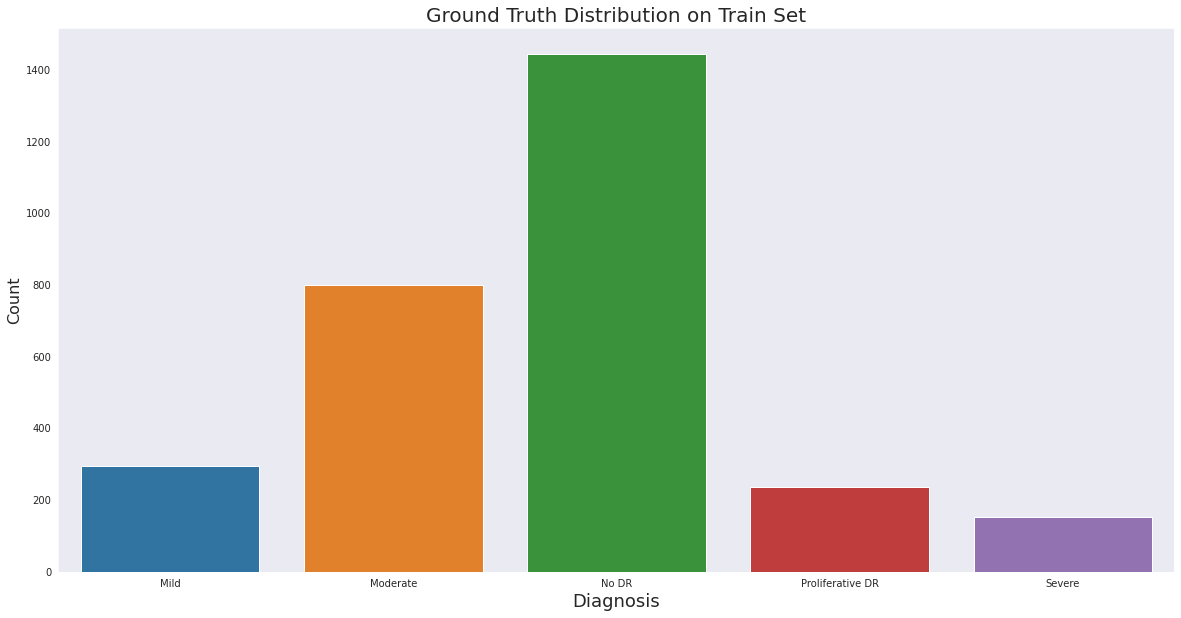

In [7]:
sns.set_style("dark")

plt.figure(figsize=(20, 10))
sns.countplot(sorted(train_labels.diagnosis_string))
plt.title('Ground Truth Distribution on Train Set', fontdict={'fontsize':20})
plt.xlabel('Diagnosis', fontsize=18) 
plt.ylabel('Count', fontsize=16)

plt.savefig('train_lables_distribution.png')
plt.show()

## Target / Ground Truth Distribution in the Validation Set.

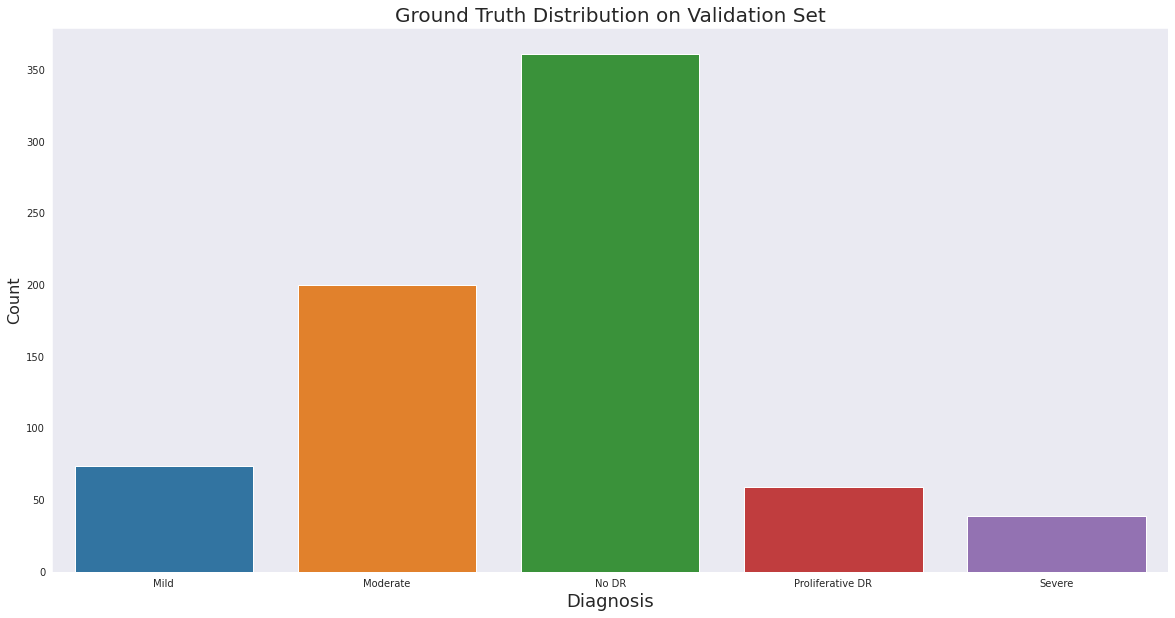

In [8]:
sns.set_style("dark")

plt.figure(figsize=(20, 10))
sns.countplot(sorted(val_labels.diagnosis_string))
plt.title('Ground Truth Distribution on Validation Set', fontdict={'fontsize':20})
plt.xlabel('Diagnosis', fontsize=18) 
plt.ylabel('Count', fontsize=16)
plt.savefig('validation_lables_distribution.png')
plt.show()

# Data Augmentation and Preprocessing.

In [9]:
def show_batch(image_batch, label_batch=None, title=''):
    fig = plt.figure(figsize=(15, 15))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    
#     xy = int(np.sqrt(image_batch.shape[0]))
    xy = image_batch.shape[0] // 2
    
    for n in range(image_batch.shape[0]):
        ax = fig.add_subplot(xy, xy, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        plt.tight_layout()
        plt.axis("off")
        
    plt.savefig(f'{title}.png')
    plt.show()

In [10]:
import tensorflow_addons as tfa
import tensorflow as tf 
import cv2

In [11]:
IMG_SIZE = 512 # 224
BATCH_SIZE = 12 # 48

RADN_CROP_IMG_SIZE = 384 # 150

In [12]:
def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [13]:
# https://github.com/tensorflow/models
@tf.function
def equalize(image, mode='grayscale'):
    def scale_channel(im, c):
        """Scale the data in the channel to implement equalize."""
        im = tf.cast(im[..., c], tf.int32)
        # Compute the histogram of the image channel.
        histo = tf.histogram_fixed_width(im, [0, 255], nbins=256)

        # For the purposes of computing the step, filter out the nonzeros.
        nonzero = tf.where(tf.not_equal(histo, 0))
        nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
        step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 255

        def build_lut(histo, step):
            # Compute the cumulative sum, shifting by step // 2
            # and then normalization by step.
            lut = (tf.cumsum(histo) + (step // 2)) // step
            # Shift lut, prepending with 0.
            lut = tf.concat([[0], lut[:-1]], 0)
            # Clip the counts to be in range.  This is done
            # in the C code for image.point.
            return tf.clip_by_value(lut, 0, 255)

        # If step is zero, return the original image.  Otherwise, build
        # lut from the full histogram and step and then index from it.
        result = tf.cond(
            tf.equal(step, 0), lambda: im,
            lambda: tf.gather(build_lut(histo, step), im))
        return tf.cast(result, tf.uint8)

    if mode == 'grayscale':
        image = scale_channel(image, 0)
        return tf.cast(image, tf.float32)
    elif mode == 'rgb':
        s1 = scale_channel(image, 0)
        s2 = scale_channel(image, 1)
        s3 = scale_channel(image, 2)
        image = tf.stack([s1, s2, s3], -1)
        return tf.cast(image, tf.float32)

In [14]:
# SetAutoTune
AUTOTUNE = tf.data.AUTOTUNE  

def build_augmenter():
    def augment(img):
        img = tf.image.random_crop(img, size=[RADN_CROP_IMG_SIZE + 10, 
                                              RADN_CROP_IMG_SIZE + 10, 3])
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, 0.95, 1.05)
        img = tf.image.random_brightness(img, 0.05)
        img = tf.image.random_contrast(img, 0.95, 1.05)
        img = tf.image.random_hue(img, 0.05)
        
        img = tf.cond(tf.random.uniform([]) >= 0.5, 
                      lambda: tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(img)), 
                      lambda: img)
        img = tf.cond(tf.random.uniform([]) >= 0.5, 
                      lambda: tfa.image.rotate(img, tf.constant(np.pi/8)), 
                      lambda: img)

        img = dropout(img, DIM=IMG_SIZE, PROBABILITY=0.7, CT=5, SZ=0.1)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    return augment_with_labels 

def build_decoder():
    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels = 3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tfa.image.equalize(img)
        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.one_hot(label, depth=5) 
    
    return decode_with_labels 

def create_dataset(df, 
                   batch_size  = 32, 
                   augment     = False, 
                   shuffle     = False):
    decode_fn    = build_decoder()
    augmenter_fn = build_augmenter()
    
    # Create Dataset
    dataset = tf.data.Dataset.from_tensor_slices((df['id_code'].values, 
                                                  df['diagnosis'].values))
    
    dataset = dataset.map(decode_fn, num_parallel_calls = AUTOTUNE)
    dataset = dataset.map(augmenter_fn, num_parallel_calls = AUTOTUNE) if augment else dataset
    
    dataset = dataset.repeat() if shuffle else dataset 
    dataset = dataset.shuffle(1024, reshuffle_each_iteration = True) if shuffle else dataset

    dataset = dataset.batch(batch_size,  drop_remainder=shuffle)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [15]:
training_dataset = create_dataset(
    train_labels,
    batch_size  = BATCH_SIZE, 
    augment = True,
    shuffle = True
)

In [16]:
# sample_images, sample_labels = next(iter(training_dataset))
# show_batch(sample_images.numpy(), 
#            label_batch=sample_labels.numpy(), 
#            title='Augmented Training Set')

In [17]:
validation_dataset = create_dataset(
    val_labels,
    batch_size=BATCH_SIZE, 
    augment = False,
    shuffle = False
)

In [18]:
# sample_images, sample_labels = next(iter(validation_dataset))
# show_batch(
#     sample_images.numpy(), 
#     label_batch=sample_labels.numpy(), 
#     title='Validation Set'
# )

# Paper Model

In [19]:
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Input, Model, layers, applications

In [20]:
# input = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# block_a = keras.Sequential([
#     layers.Conv2D(filters = 32, kernel_size = 3, strides=1),
#     layers.Conv2D(filters = 32, kernel_size = 3, strides=1),
#     layers.Dropout(0.5),
#     layers.MaxPooling2D(pool_size=(3, 3), strides=2)
#     ], 
#     name='FirstBranch'
# )

# output_a =  block_a(input)
# print(output_a.shape)


# block_b = keras.Sequential([
#     layers.Conv2D(filters = 64, kernel_size = 3, strides=1),
#     layers.Conv2D(filters = 64, kernel_size = 3, strides=1),
#     layers.MaxPooling2D(pool_size=(3, 3), strides=2),
#     layers.Dropout(0.5),
#     ], 
#     name='SecondBranch'
# )

# output_b =  block_b(input)
# print(output_b.shape)


# block_c = keras.Sequential([
#     layers.Conv2D(filters = 128, kernel_size = 3, strides=1),
#     layers.Conv2D(filters = 128, kernel_size = 3, strides=1),
#     layers.MaxPooling2D(pool_size=(3, 3), strides=2),
#     layers.Dropout(0.5),
#     ], 
#     name='ThirdBranch'
# )

# output_c = block_c(input)
# print(output_c.shape)

# merged = layers.Concatenate(axis=-1)([output_a, output_b, output_c])
# merged = layers.GlobalAveragePooling2D(name='gapc')(merged)
# classifier = layers.Dense(5, activation='softmax')(merged)
# model = keras.Model(inputs = input, outputs=classifier)

# Our Model (Ensembling)

In [21]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = keras.applications.EfficientNetB0(
    input_tensor=inputs, 
    include_top=False,
    weights='imagenet'
)




y_scale = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
y = keras.applications.DenseNet121(
    input_tensor=y_scale, 
    include_top=False,
    weights='imagenet'
)
for layer in y.layers:
    layer._name = 'y1_' + str(layer._name)

    
    
    
z_scale = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
z = keras.applications.ResNet50(
    input_tensor=z_scale, 
    include_top=False,
    weights='imagenet'
)
for layer in z.layers:
    layer._name = 'z2_' + str(layer._name)



merged = layers.Concatenate(axis=-1, name='group_models')([x.output, y.output, z.output])
merged = layers.GlobalAveragePooling2D(name='gapc')(merged)
classifier = layers.Dense(5, activation='softmax', dtype=tf.float32)(merged)

keras.backend.clear_session()
model = keras.Model(inputs, classifier)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# display(keras.utils.plot_model(model, show_shapes=True, expand_nested=False, to_file='model.png'))
# model.summary()

In [22]:
TRAIN_STEPS_PER_EPOCH = int(np.ceil(len(train_labels) / float(BATCH_SIZE)))
VALID_STEPS_PER_EPOCH = int(np.ceil(len(val_labels) / float(BATCH_SIZE)))
EPOCHS = 15

TRAIN_STEPS_PER_EPOCH, VALID_STEPS_PER_EPOCH

(245, 62)

In [23]:
from tensorflow.keras import losses, metrics, optimizers, callbacks
import tensorflow_addons as tfa

METRICS = [
    tfa.metrics.CohenKappa(
        num_classes=5,
        weightage="quadratic",
        name="qwk"
    ),
    metrics.CategoricalAccuracy(name='acc')
]

In [24]:
my_callbacks = [
    callbacks.CSVLogger('history.csv'),
    
    callbacks.ModelCheckpoint(
        filepath='model_acc.h5', 
        save_weights_only=True, 
        monitor='val_acc', 
        mode='max'
    ),
    
    callbacks.ModelCheckpoint(
        filepath='model_qwk.h5', 
        save_weights_only=True, 
        monitor='val_qwk', 
        mode='max'
    ),
 
    callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.3,
        patience=1,
        verbose=0,
        mode="max",
        epsilon=0.0001,
        cooldown=1,
        min_lr=0.00001
    )
]

In [25]:
train = False
fine_tune = False

In [26]:
opt = optimizers.Adam(learning_rate=1e-4 if not fine_tune else 1e-5)

model.compile(
    loss      = losses.CategoricalCrossentropy(),
    metrics   = METRICS,
    optimizer = opt
) 

if train:
    history = model.fit( 
        training_dataset,
        steps_per_epoch  = TRAIN_STEPS_PER_EPOCH,
        validation_data  = validation_dataset, 
        epochs = EPOCHS,
        callbacks = my_callbacks,
    )
elif fine_tune: 
    print('FINE TUNE ...')
    model.load_weights('../input/tempset/model_acc.h5')
    history = model.fit( 
        training_dataset,
        steps_per_epoch  = TRAIN_STEPS_PER_EPOCH,
        validation_data  = validation_dataset, 
        epochs = EPOCHS,
        callbacks = my_callbacks,
    )
else:
    model.load_weights('../input/aptostest/best_ckpt.h5')

# Evaluation

```
- Learning Curve
- Confusion Matrix
- Classification Report (Accuracy, Precision, Recall, F1-Score)
- Quadratic Cohen Kappa
- Grad-CAM
```

epoch       67.000000
acc          0.942351
loss         0.304540
qwk          0.973320
val_acc      0.939973
val_loss     0.383158
val_qwk      0.963310
Name: 67, dtype: float64


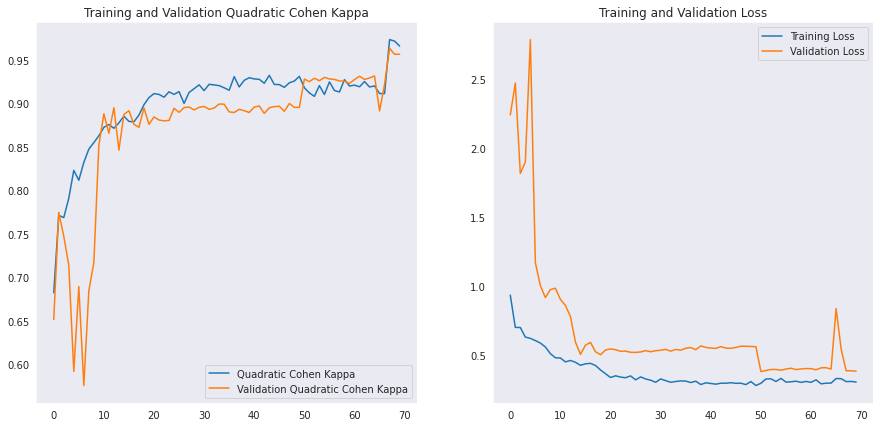

In [27]:
if train:
    qwk     = history.history['qwk'] 
    val_qwk = history.history['val_qwk'] 

    loss     = history.history['loss']
    val_loss = history.history['val_loss']
else:
    history = pd.read_csv('../input/aptostest/history.csv')
    qwk     = history['qwk'] 
    val_qwk = history['val_qwk'] 

    loss     = history['loss']
    val_loss = history['val_loss']
    
    print(history.loc[history['val_qwk'].idxmax()])

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(history.shape[0]), qwk, label='Quadratic Cohen Kappa')
plt.plot(range(history.shape[0]), val_qwk, label='Validation Quadratic Cohen Kappa')
plt.legend(loc='lower right')
plt.title('Training and Validation Quadratic Cohen Kappa')

plt.subplot(1, 2, 2)
plt.plot(range(history.shape[0]), loss, label='Training Loss')
plt.plot(range(history.shape[0]), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(f'Learning Curve.png')
plt.show()

In [ ]:
# val_labels.sample(1)

In [28]:
from tqdm import tqdm

oof_pred  = []
oof_tar   = []
oof_names = []

for index, row in tqdm(val_labels.iterrows(), total=len(val_labels)):
    # prepare image 
    image_file = os.path.join(row['id_code'])
    image_arry = cv2.imread(image_file)[:,:,::-1]
    image_arry = cv2.resize(image_arry, (IMG_SIZE, IMG_SIZE))
    image_arry = tfa.image.equalize(image_arry)
    batch_image_arry = image_arry[None, ...]
 
    # prediction 
    ypred = model.predict(batch_image_arry)
    ypred = np.argmax(ypred, axis=1)
    
    # save meta info
    oof_pred.append(ypred)
    oof_tar.append(row['diagnosis'])
    oof_names.append(row['id_code'])

100%|██████████| 733/733 [03:09<00:00,  3.86it/s]


In [29]:
oof_tar = [np.array([item]) for item in oof_tar]
oof_names = [np.array([item]) for item in oof_names]

oof   = np.concatenate(oof_pred)
true  = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
print(oof.shape, true.shape, names.shape)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_id = names, 
    target   = true, 
    pred     = oof
))

(733,) (733,) (733,)


In [30]:
df_oof.to_csv('oof.csv', index=False)
df_oof.head(10)

,image_id,target,pred
0,../input/aptos2019-blindness-detection/train_i...,2,1
1,../input/aptos2019-blindness-detection/train_i...,0,0
2,../input/aptos2019-blindness-detection/train_i...,2,1
3,../input/aptos2019-blindness-detection/train_i...,2,2
4,../input/aptos2019-blindness-detection/train_i...,0,0
5,../input/aptos2019-blindness-detection/train_i...,0,0
6,../input/aptos2019-blindness-detection/train_i...,0,0
7,../input/aptos2019-blindness-detection/train_i...,0,0
8,../input/aptos2019-blindness-detection/train_i...,0,0
9,../input/aptos2019-blindness-detection/train_i...,0,0


In [31]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import cohen_kappa_score

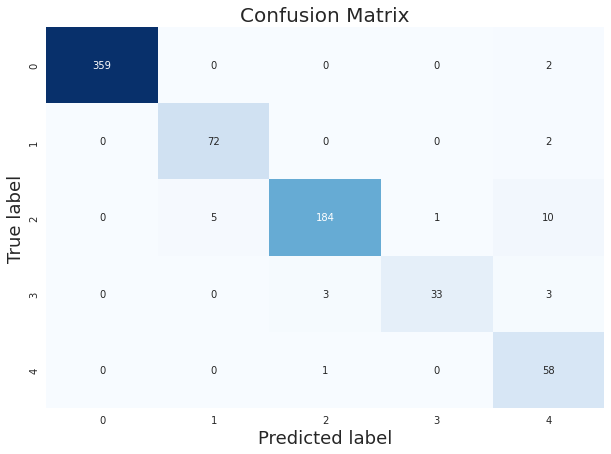

In [32]:
# set plot figure size for better view
plt.figure(figsize=(10,7))
conf_mat = confusion_matrix(df_oof['target'], df_oof['pred'])
sns.heatmap(conf_mat, annot=True, fmt="d", cbar = False,  cmap = plt.cm.Blues)

plt.title('Confusion Matrix', fontdict={'fontsize':20})
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.savefig(f'Confusion Matrix.png')
plt.show()

In [33]:
target = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

print('Acc: %2.2f%%' %(100*accuracy_score(df_oof['target'], df_oof['pred'])))
print(classification_report(df_oof['target'], df_oof['pred'], target_names = target))

Acc: 96.32%
                  precision    recall  f1-score   support

           No DR       1.00      0.99      1.00       361
            Mild       0.94      0.97      0.95        74
        Moderate       0.98      0.92      0.95       200
          Severe       0.97      0.85      0.90        39
Proliferative DR       0.77      0.98      0.87        59

        accuracy                           0.96       733
       macro avg       0.93      0.94      0.93       733
    weighted avg       0.97      0.96      0.96       733



# Quadratic Cohen Kappa

In [43]:
print('Overall Validation QWK:', cohen_kappa_score(df_oof['target'], df_oof['pred'], weights='quadratic'))
print('Overall Validation Accuracy:', accuracy_score(df_oof['target'], df_oof['pred']))

Overall Validation QWK: 0.9588303054901757
Overall Validation Accuracy: 0.9631650750341064


# Grad-CAM (Visualization: Interpretability)

In [49]:
index = 2

x, y = next(iter(validation_dataset))
x.shape, y.shape
x[index, None, ...].shape

TensorShape([1, 512, 512, 3])

In [50]:
grad_model = keras.models.Model(
    [model.inputs], 
    [
        model.get_layer('group_models').output, 
        model.output
     ]
)

image = x[0, None, ...]

with tf.GradientTape() as tape:
    convOutputs, predictions = grad_model(tf.cast(image, tf.float32))
    loss = predictions[:, tf.argmax(predictions[0])]

grads = tape.gradient(loss, convOutputs)
print(grads.shape) 

(1, 16, 16, 4352)


In [51]:
# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
convOutputs = convOutputs[0]
heatmap = convOutputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

In [52]:
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.6):
    # Load the original image
    img = img_path

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img 

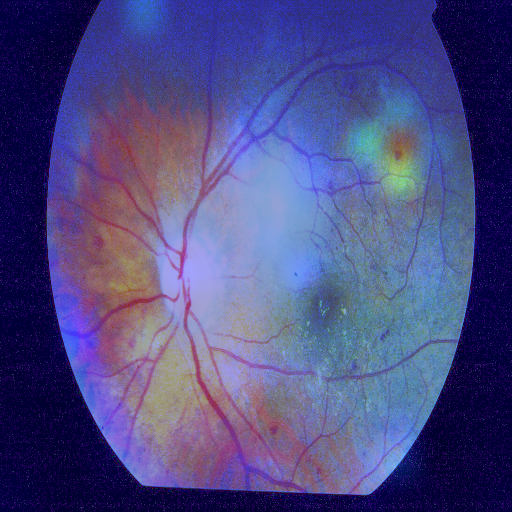

In [54]:
save_and_display_gradcam(image[0], heatmap)

In [ ]:
# save_and_display_gradcam(image[0], heatmap)